# CMS General Hospital Information - Exploratory Data Analysis
---
### Which states/counties have the lowest quality of care metrics within their hospitals?
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from get_cleaned_cms import cms

In [69]:
# Define custom color palette for all plots by state
custom_palette = {'Mississippi': '#ee9200', 'Louisiana': '#1d4589', 'Alabama': '#d71200'}
shortage_palette = {'Non-Shortage Area': '#C7BEAF', 'Shortage Area': '#0E4AA0'}

# Define custom parameters for all plots
custom_params = {
    "figure.facecolor": "#f1f2f2",
    "axes.facecolor": "#f1f2f2",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 14,
    "axes.titleweight": "bold",
    "axes.titlesize": 16  
}

sns.set_theme(style = 'ticks', font = 'Arial', rc = custom_params)

In [3]:
# Export cleaned cms dataframe to csv
# cms.to_csv('cleaned_data/cms.csv', index = False)

# Get info about cleaned cms dataframe
cms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2704 entries, 0 to 2703
Data columns (total 53 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Year                                                   2704 non-null   int64  
 1   Quarter                                                2704 non-null   object 
 2   Facility ID                                            2704 non-null   object 
 3   Facility Name                                          2704 non-null   object 
 4   City                                                   2704 non-null   object 
 5   State                                                  2704 non-null   object 
 6   ZIP Code                                               2704 non-null   int64  
 7   Hospital Type                                          2704 non-null   object 
 8   Hospital Ownership                              

---
### How many hospitals from each state are represented for each year?  How many counties?

In [4]:
# Get hospital sample size
cms.groupby(['Year', 'State'])['Facility ID'].count()

Year  State      
2016  Alabama         89
      Louisiana      122
      Mississippi     96
2017  Alabama         91
      Louisiana      121
      Mississippi     95
2018  Alabama         91
      Louisiana      119
      Mississippi     95
2019  Alabama         99
      Louisiana      154
      Mississippi    101
2020  Alabama         97
      Louisiana      153
      Mississippi    100
2021  Alabama         99
      Louisiana      156
      Mississippi    101
2022  Alabama         98
      Louisiana      158
      Mississippi    103
2023  Alabama        100
      Louisiana      161
      Mississippi    105
Name: Facility ID, dtype: int64

In [5]:
# Get county sample size
cms.groupby(['Year', 'State'])['Common State County FIPS Code'].nunique()

Year  State      
2016  Alabama        58
      Louisiana      56
      Mississippi    75
2017  Alabama        59
      Louisiana      56
      Mississippi    74
2018  Alabama        59
      Louisiana      56
      Mississippi    74
2019  Alabama        59
      Louisiana      57
      Mississippi    74
2020  Alabama        59
      Louisiana      57
      Mississippi    72
2021  Alabama        59
      Louisiana      57
      Mississippi    72
2022  Alabama        59
      Louisiana      57
      Mississippi    73
2023  Alabama        59
      Louisiana      57
      Mississippi    73
Name: Common State County FIPS Code, dtype: int64

---
### Get sample size for Hospital overall star rating in each state based on hospital type.

Count the number of acute care hospitals in each state.

In [6]:
# Define the hospital type of interest
acute_types = ['Acute Care Hospitals', 'Acute Care - Veterans Administration', 'Acute Care - Department of Defense']

# Subset the cms dataframe, keeping only rows from acute care hospitals, and dropping rows that have nulls in star rating
acute_subset = cms[cms['Hospital Type'].isin(acute_types)].dropna(subset = ['Hospital overall rating'])

# For each state, group by facility id (since a hospital has a row for each year, and count the number of unique facilities
acute_facilities = acute_subset.groupby(['State', 'Facility ID'])['Facility ID'].nunique().reset_index(name = 'Unique Facility IDs')

acute_facilities.groupby('State')['Unique Facility IDs'].count()

State
Alabama        83
Louisiana      79
Mississippi    54
Name: Unique Facility IDs, dtype: int64

Count the number of acute care hospitals by shortage designation in each state.

In [7]:
# For each state, group by facility id (since a hospital has a row for each year, and count the number of unique facilities
acute_facilities = acute_subset.groupby(['State', 'County HPSA Status', 'Facility ID'])['Facility ID'].nunique().reset_index(name = 'Unique Facility IDs')

acute_facilities.groupby(['State', 'County HPSA Status'])['Unique Facility IDs'].count()

State        County HPSA Status
Alabama      Non-Shortage Area     46
             Shortage Area         37
Louisiana    Non-Shortage Area     63
             Shortage Area         16
Mississippi  Non-Shortage Area     34
             Shortage Area         20
Name: Unique Facility IDs, dtype: int64

Count the number of critical access hospitals in each state.

In [8]:
# Subset the dataframe, keeping only rows from critical access hospitals, and dropping rows that have nulls in star rating
critical_subset = cms[cms['Hospital Type'] == 'Critical Access Hospitals'].dropna(subset = ['Hospital overall rating'])

# For each state, group by facility id (since a hospital has a row for each year, and count the number of unique facilities
critical_facilities = critical_subset.groupby(['State', 'Facility ID'])['Facility ID'].nunique().reset_index(name = 'Unique Facility IDs')

critical_facilities.groupby('State')['Unique Facility IDs'].count()

State
Alabama         1
Louisiana      12
Mississippi    18
Name: Unique Facility IDs, dtype: int64

---
#### For each year and state, how many hospitals were given star ratings?

In [9]:
# Get number of hospitals with star ratings sample size
cms.groupby(['Year', 'State'])['Hospital overall rating'].count()

Year  State      
2016  Alabama        79
      Louisiana      80
      Mississippi    63
2017  Alabama        79
      Louisiana      79
      Mississippi    63
2018  Alabama        81
      Louisiana      78
      Mississippi    64
2019  Alabama        77
      Louisiana      81
      Mississippi    65
2020  Alabama        76
      Louisiana      76
      Mississippi    62
2021  Alabama        70
      Louisiana      72
      Mississippi    54
2022  Alabama        65
      Louisiana      64
      Mississippi    49
2023  Alabama        61
      Louisiana      61
      Mississippi    49
Name: Hospital overall rating, dtype: int64

---
### Which states have the highest average hospital overall star rating across all years?
#### **Answer: Louisiana (3.05 stars), followed by Alabama (2.97 stars) and Mississippi (2.64 stars).**

In [10]:
cms.groupby('State')['Hospital overall rating'].describe()

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Alabama,588.0,2.972789,0.88096,1.0,2.0,3.0,4.0,5.0
Louisiana,591.0,3.052453,0.929164,1.0,2.0,3.0,4.0,5.0
Mississippi,469.0,2.641791,0.969427,1.0,2.0,3.0,3.0,5.0


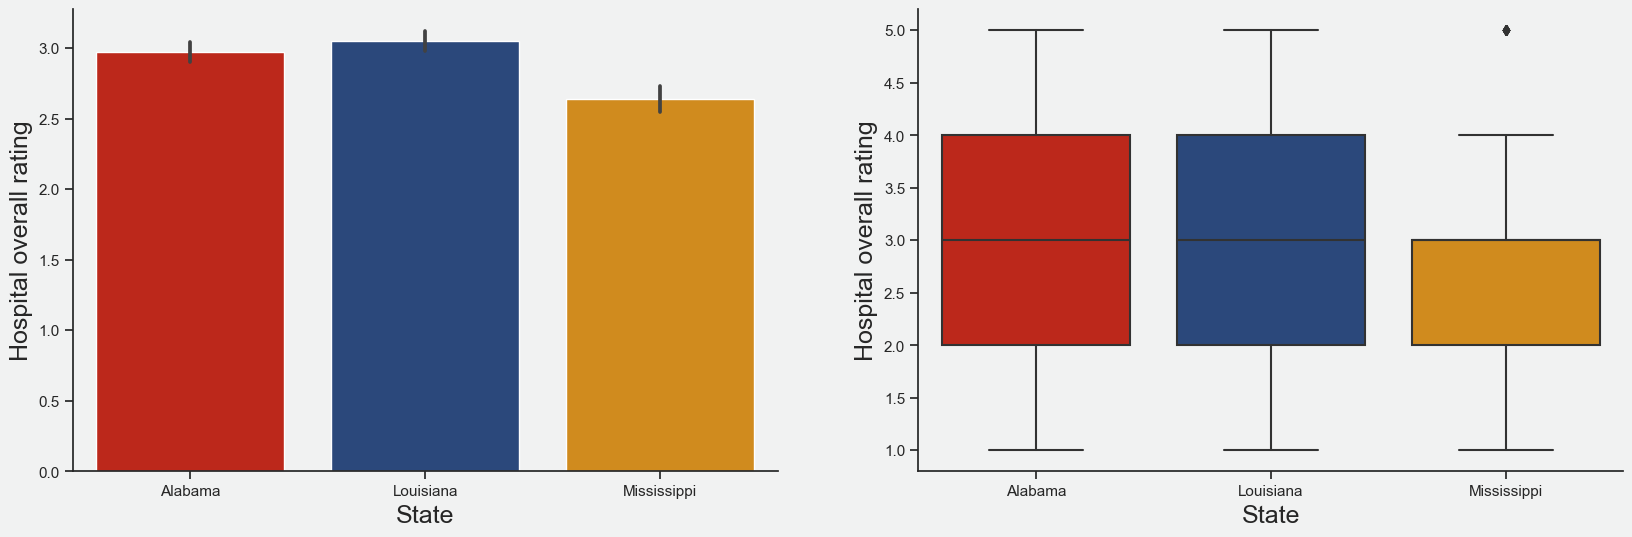

In [11]:
# Create barplot and boxplot for Hospital overall rating by state
cms_cleaned = cms.dropna(subset = ['Hospital overall rating', 'State'])

plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_cleaned, x = 'State', y = 'Hospital overall rating', palette = custom_palette)

plt.subplot(1, 2, 2)
sns.boxplot(cms_cleaned, x = 'State', y = 'Hospital overall rating', palette = custom_palette)

plt.show()

---
### How has the average overall hospital star rating changed over time by state?
#### **Answer: Mississippi has star ratings consistently between 2.4 and 2.8 stars, with ratings dropping below 2.7 over the last three years.  Louisiana & Alabama have star ratings consistently between 2.9 and 3.1, however both have received lower star ratings than normal in 2023 (2.8 and 2.6, respectively).**

In [12]:
cms.groupby(['State', 'Year'])['Hospital overall rating'].describe()

count      mean       std  min   25%  50%  75%  max
State       Year                                                     
Alabama     2016   79.0  3.050633    0.7143  2.0   3.0  3.0  3.0  5.0
            2017   79.0  3.050633    0.7143  2.0   3.0  3.0  3.0  5.0
            2018   81.0  2.975309  0.805843  2.0   2.0  3.0  4.0  5.0
            2019   77.0  2.896104   1.00766  1.0   2.0  3.0  4.0  5.0
            2020   76.0  3.039474  0.972156  2.0   2.0  3.0  4.0  5.0
            2021   70.0  3.085714  0.974201  1.0   2.0  3.0  4.0  5.0
            2022   65.0  3.015385  0.856817  2.0   2.0  3.0  4.0  5.0
            2023   61.0  2.606557  0.935925  1.0   2.0  3.0  3.0  5.0
Louisiana   2016   80.0     3.125  0.682048  1.0   3.0  3.0  4.0  5.0
            2017   79.0  3.126582  0.686259  1.0   3.0  3.0  4.0  5.0
            2018   78.0  3.115385  0.980071  1.0  2.25  3.0  4.0  5.0
            2019   81.0  3.012346  0.873124  1.0   2.0  3.0  4.0  5.0
            2020   76.0  2.921053  0.905732  1.0   2.0  3.0  3.0  5.0
            2021   72.0  3.194444  1.121353  1.0  2.75  3.0  4.0  5.0
            2022   64.0    3.0625   1.12511  1.0   2.0  3.0  4.0  5.0
            2023   61.0  2.819672  1.024828  1.0   2.0  3.0  4.0  5.0
Mississippi 2016   63.0  2.777778  0.750149  1.0   2.0  3.0  3.0  4.0
            2017   63.0  2.777778  0.750149  1.0   2.0  3.0  3.0  4.0
            2018   64.0   2.65625  0.995526  1.0   2.0  3.0  3.0  5.0
            2019   65.0  2.569231   0.86547  1.0   2.0  3.0  3.0  5.0
            2020   62.0  2.725806  1.042842  1.0   2.0  3.0  3.0  5.0
            2021   54.0  2.574074   1.07461  1.0   2.0  2.0  3.0  5.0
            2022   49.0  2.408163  1.097694  1.0   2.0  2.0  3.0  5.0
            2023   49.0  2.571429  1.190238  1.0   2.0  2.0  3.0  5.0

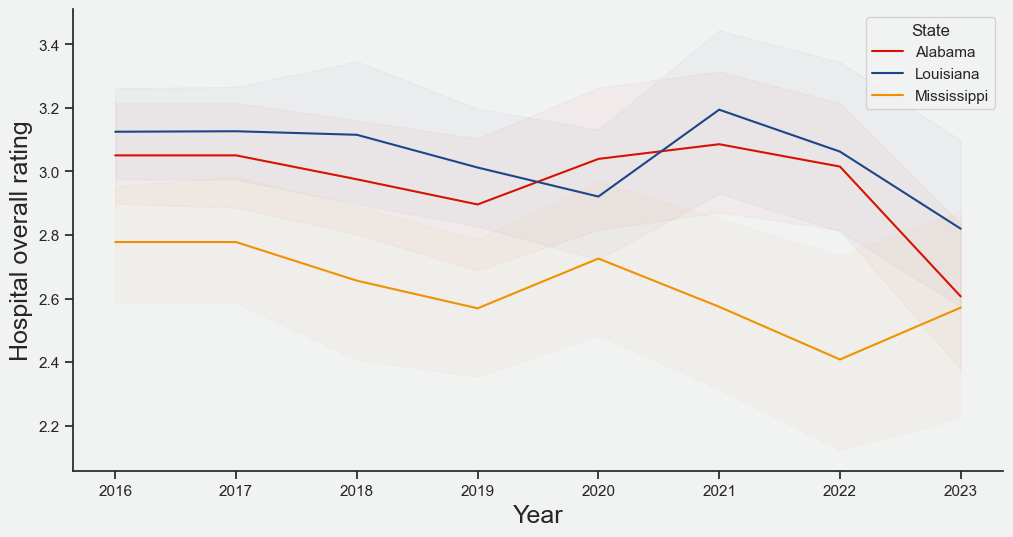

In [13]:
# Create line plot for Hospital overall rating by year and state
plt.figure(figsize = (12, 6))

sns.lineplot(cms, x = 'Year', y = 'Hospital overall rating', hue = 'State',
             palette = custom_palette, err_kws = {'alpha': 0.03})

plt.show()

---
### How do the average hospital star ratings compare in shortage areas versus non-shortage areas for these states across all years?
#### **Answer: Surprisingly, for Mississippi & Alabama, hospitals in counties designated as shortage areas have star ratings that are HIGHER on average compared to hospitals in non-shortage areas.  There is no difference in star ratings between hospitals in shortage vs. non-shortage counties for Louisiana.**

In [14]:
cms.groupby(['State', 'County HPSA Status'])['Hospital overall rating'].describe()

count      mean       std  min  25%  50%  75%  \
State       County HPSA Status                                                  
Alabama     Non-Shortage Area   342.0  2.769006  0.857521  1.0  2.0  3.0  3.0   
            Shortage Area       246.0  3.256098  0.835112  1.0  3.0  3.0  4.0   
Louisiana   Non-Shortage Area   455.0  3.048352  0.967462  1.0  2.0  3.0  4.0   
            Shortage Area       136.0  3.066176  0.790707  1.0  3.0  3.0  4.0   
Mississippi Non-Shortage Area   268.0   2.44403  0.990896  1.0  2.0  2.0  3.0   
            Shortage Area       201.0  2.905473  0.875226  1.0  2.0  3.0  3.0   

                                max  
State       County HPSA Status       
Alabama     Non-Shortage Area   5.0  
            Shortage Area       5.0  
Louisiana   Non-Shortage Area   5.0  
            Shortage Area       5.0  
Mississippi Non-Shortage Area   5.0  
            Shortage Area       5.0

/var/folders/19/md1d568j3j72wrqkm3yr4s8r0000gn/T/ipykernel_11391/924645785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cms_cleaned['Hospital overall rating'] = cms_cleaned['Hospital overall rating'].astype(int)


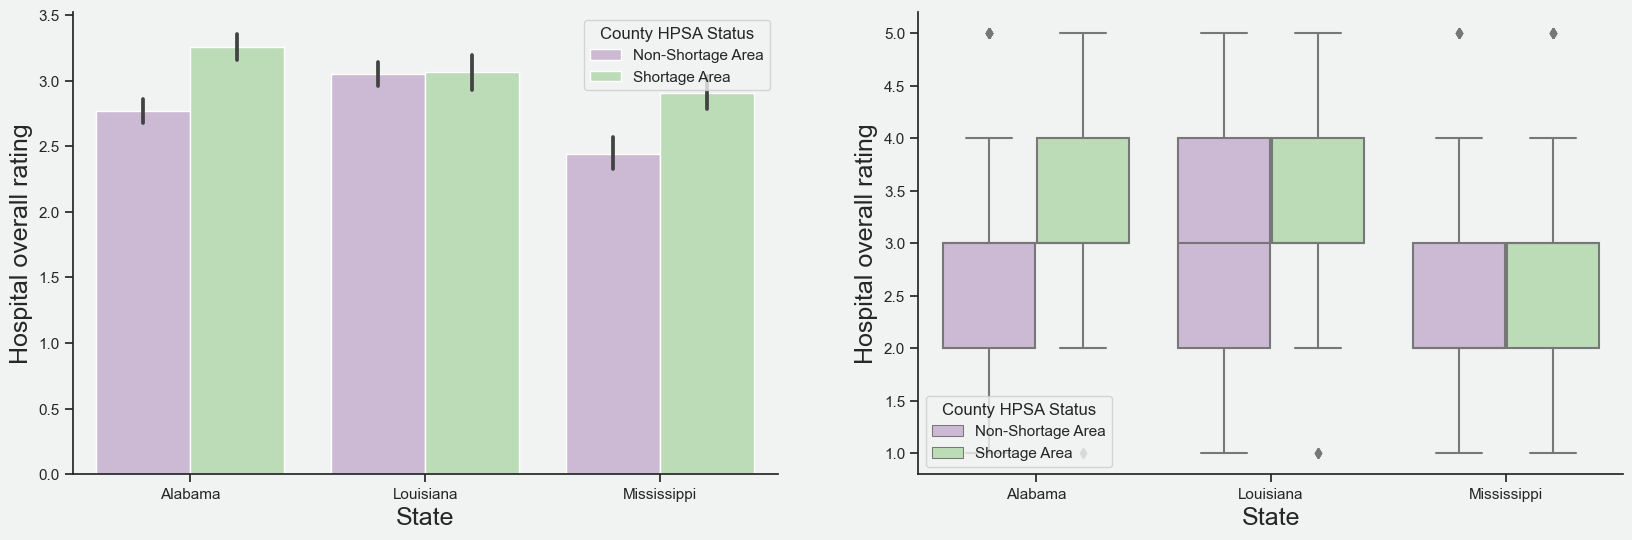

In [15]:
# Create barplot and boxplot for Hospital overall rating by HPSA County Status and state
cms_cleaned = cms.dropna(subset = ['Hospital overall rating', 'County HPSA Status', 'State'])
cms_cleaned['Hospital overall rating'] = cms_cleaned['Hospital overall rating'].astype(int)

plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_cleaned, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'PRGn')

plt.subplot(1, 2, 2)
sns.boxplot(cms_cleaned, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'PRGn')

plt.show()

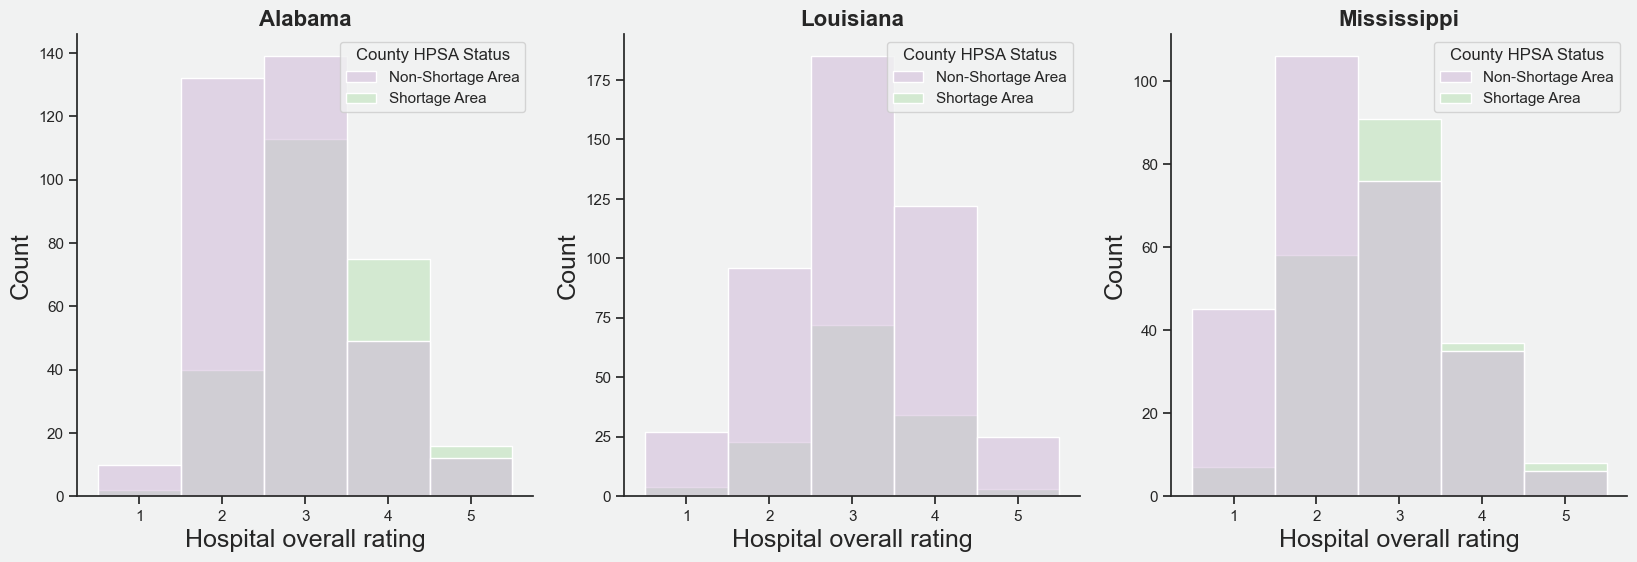

In [16]:
# Create histograms for Hospital overall rating by HPSA County Status and state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.histplot(cms_cleaned[cms_cleaned['State'] == 'Alabama'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             discrete = True, palette = 'PRGn').set(title = 'Alabama')

plt.subplot(1, 3, 2)
sns.histplot(cms_cleaned[cms_cleaned['State'] == 'Louisiana'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             discrete = True, palette = 'PRGn').set(title = 'Louisiana')

plt.subplot(1, 3, 3)
sns.histplot(cms_cleaned[cms_cleaned['State'] == 'Mississippi'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             discrete = True, palette = 'PRGn').set(title = 'Mississippi')

plt.show()

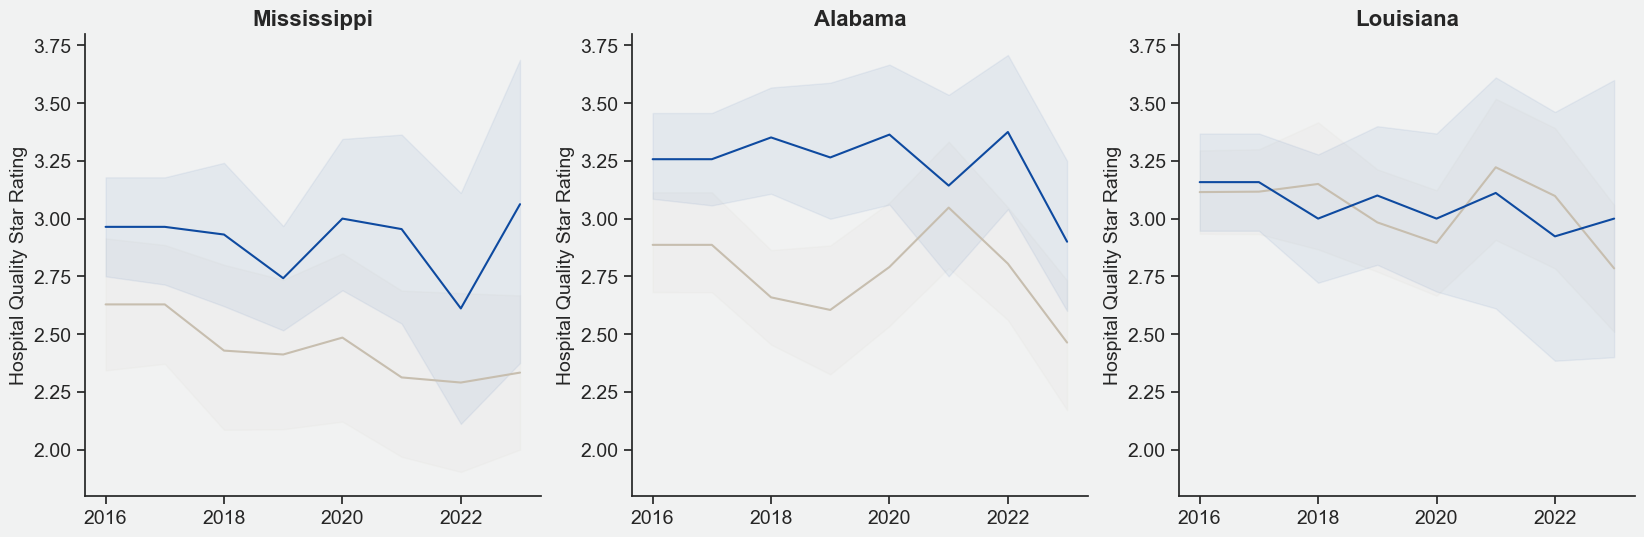

In [74]:
# Create line plot for Hospital overall rating by year, HPSA county status, & state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.lineplot(cms[cms['State'] == 'Mississippi'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = shortage_palette, legend = False,
             err_kws = {'alpha': 0.06}).set(title = 'Mississippi', ylim = (1.8, 3.8), xlabel = '', ylabel = 'Hospital Quality Star Rating')
plt.tick_params(labelsize = 14)

plt.subplot(1, 3, 2)
sns.lineplot(cms[cms['State'] == 'Alabama'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = shortage_palette, legend = False,
             err_kws = {'alpha': 0.06}).set(title = 'Alabama', ylim = (1.8, 3.8), xlabel = '', ylabel = 'Hospital Quality Star Rating')
plt.tick_params(labelsize = 14)

plt.subplot(1, 3, 3)
sns.lineplot(cms[cms['State'] == 'Louisiana'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = shortage_palette, legend = False,
             err_kws = {'alpha': 0.06}).set(title = 'Louisiana', ylim = (1.8, 3.8), xlabel = '', ylabel = 'Hospital Quality Star Rating')
plt.tick_params(labelsize = 14)

# plt.savefig("star_rating_over_time.png")

plt.show()

---
### Create KDE plots for each state's average star rating by shortage designation.

In [18]:
# Get average hospital star rating for each facility from acute_subset dataframe
hpsa_facilities = acute_subset.groupby(['State', 'County HPSA Status', 'Facility ID'])
facility_ratings = hpsa_facilities['Hospital overall rating'].mean().reset_index(level = ['State', 'County HPSA Status'])

In [19]:
# Change datatype of rating column to float
facility_ratings['Hospital overall rating'] = facility_ratings['Hospital overall rating'].astype(float)

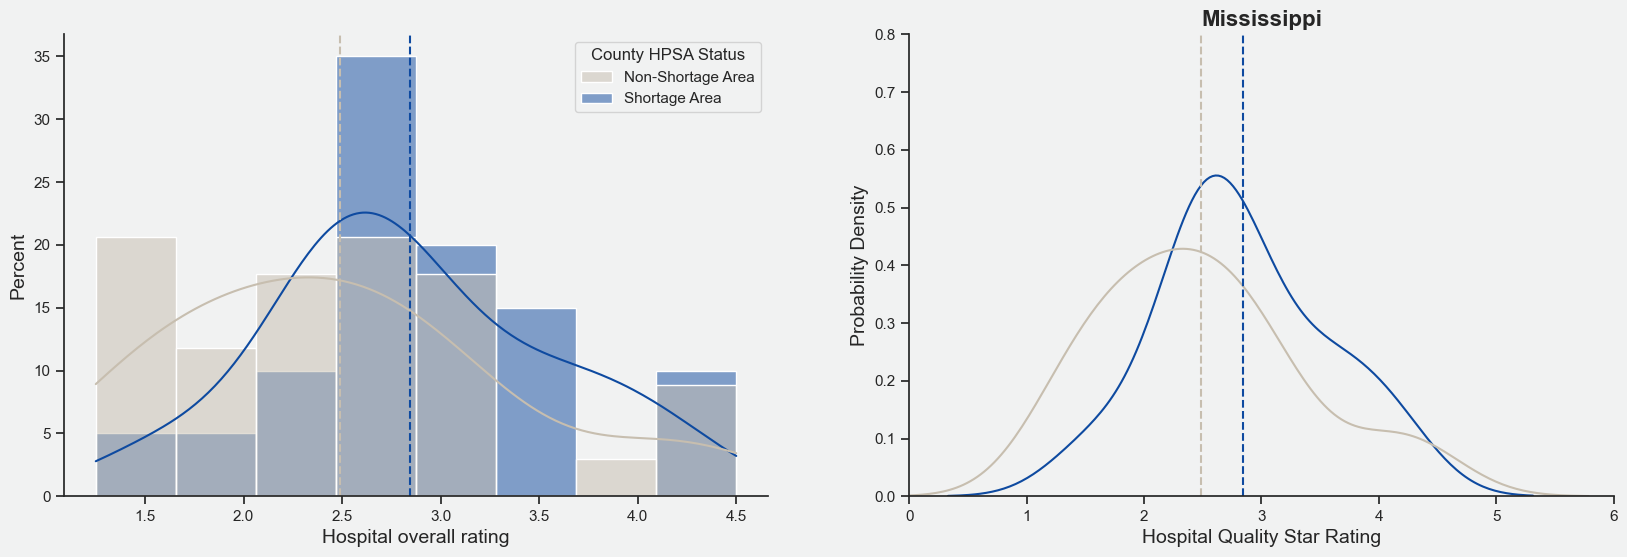

In [76]:
# Calculate means for shortage vs. non-shortage groups in Mississippi
means = facility_ratings[facility_ratings['State'] == 'Mississippi'].groupby('County HPSA Status')['Hospital overall rating'].mean()

# Create a histogram and KDE plot of HPSA Score for Mississippi
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.histplot(facility_ratings[facility_ratings['State'] == 'Mississippi'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             stat = 'percent', common_norm = False, kde = True, palette = shortage_palette)

# Get the current axis
ax = plt.gca()

# Plot vertical lines for medians
for status, mean in means.items():
    ax.axvline(x = mean, color = shortage_palette[status], linestyle = '--')

plt.subplot(1, 2, 2)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Mississippi'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette,
            legend = False).set(title = 'Mississippi', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')

# Get the current axis
ax = plt.gca()

# Plot vertical lines for medians
for status, mean in means.items():
    ax.axvline(x = mean, color = shortage_palette[status], linestyle = '--')

plt.show()

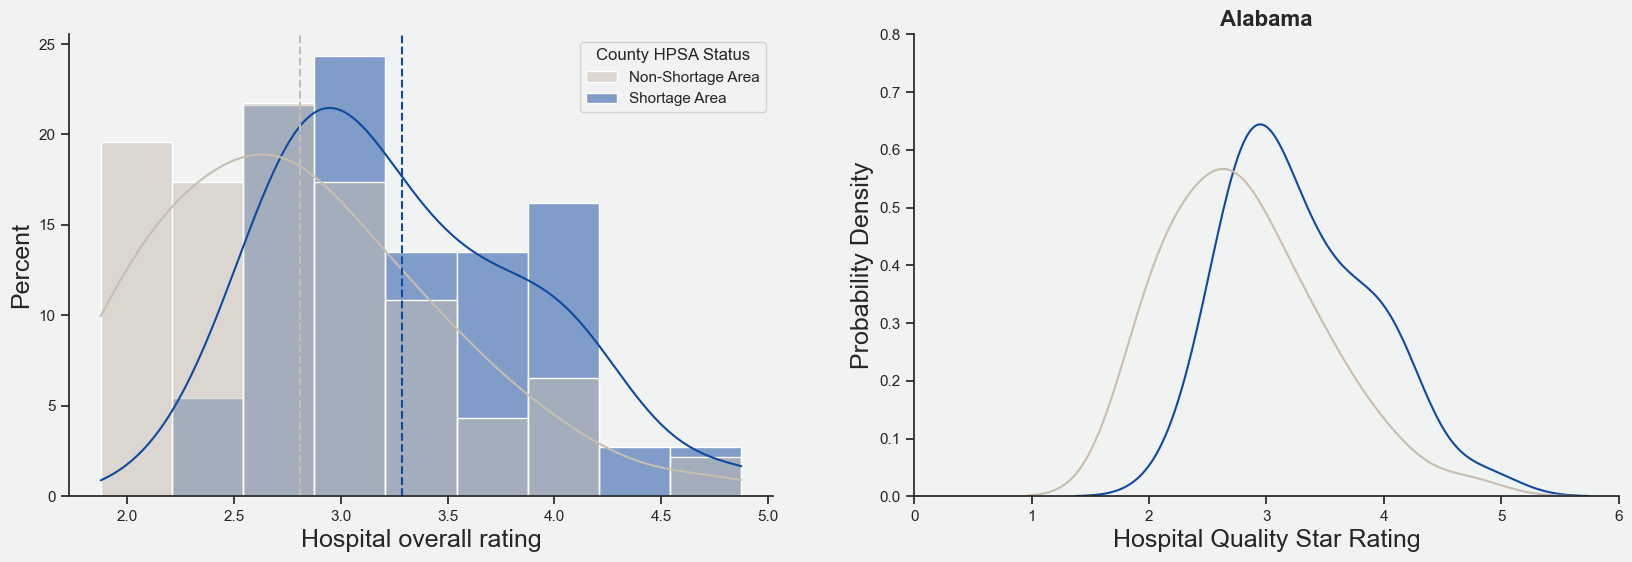

In [21]:
# Calculate means for shortage vs. non-shortage groups in Alabama
means = facility_ratings[facility_ratings['State'] == 'Alabama'].groupby('County HPSA Status')['Hospital overall rating'].mean()

# Create a histogram and KDE plot of HPSA Score for Alabama
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.histplot(facility_ratings[facility_ratings['State'] == 'Alabama'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             stat = 'percent', common_norm = False, kde = True, palette = shortage_palette)

# Get the current axis
ax = plt.gca()

# Plot vertical lines for medians
for status, mean in means.items():
    ax.axvline(x = mean, color = shortage_palette[status], linestyle = '--')

plt.subplot(1, 2, 2)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Alabama'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette,
            legend = False).set(title = 'Alabama', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')

plt.show()

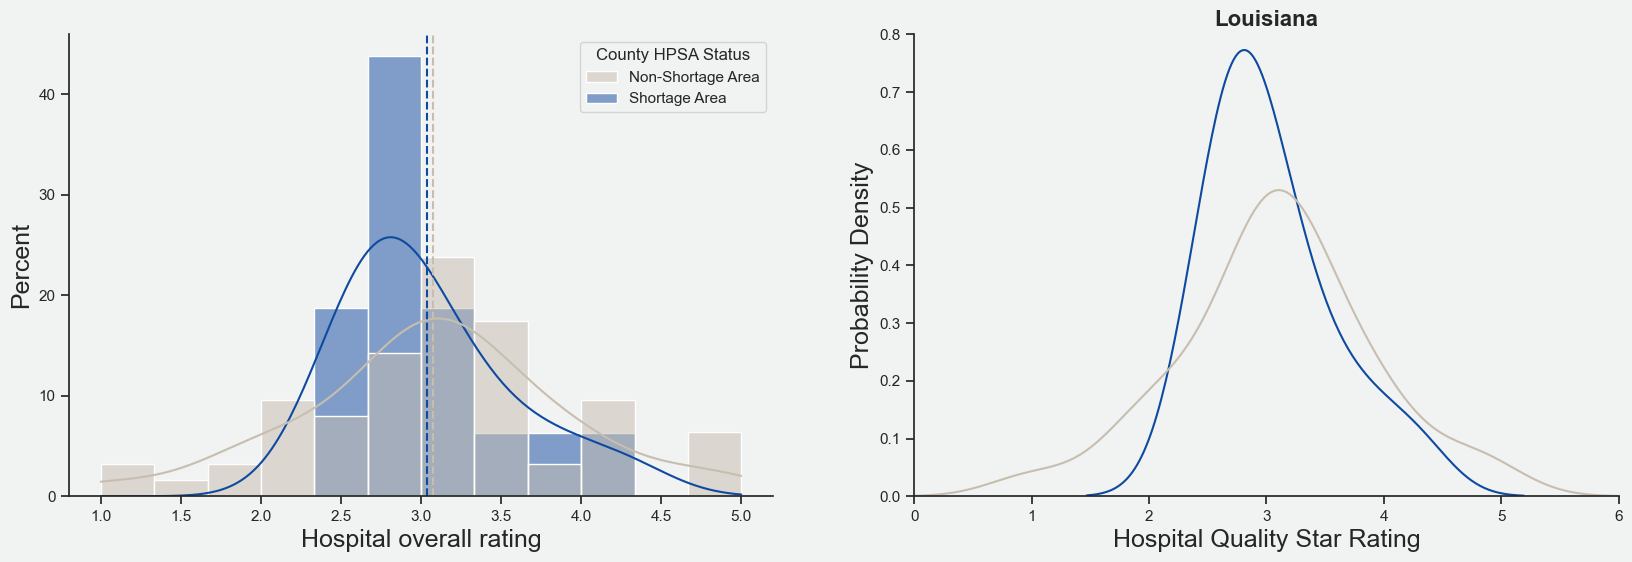

In [22]:
# Calculate means for shortage vs. non-shortage groups in Louisiana
means = facility_ratings[facility_ratings['State'] == 'Louisiana'].groupby('County HPSA Status')['Hospital overall rating'].mean()

# Create a histogram and KDE plot of HPSA Score for Alabama
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.histplot(facility_ratings[facility_ratings['State'] == 'Louisiana'], x = 'Hospital overall rating', hue = 'County HPSA Status',
             stat = 'percent', common_norm = False, kde = True, palette = shortage_palette)

# Get the current axis
ax = plt.gca()

# Plot vertical lines for medians
for status, mean in means.items():
    ax.axvline(x = mean, color = shortage_palette[status], linestyle = '--')

plt.subplot(1, 2, 2)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Louisiana'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette,
            legend = False).set(title = 'Louisiana', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')

plt.show()

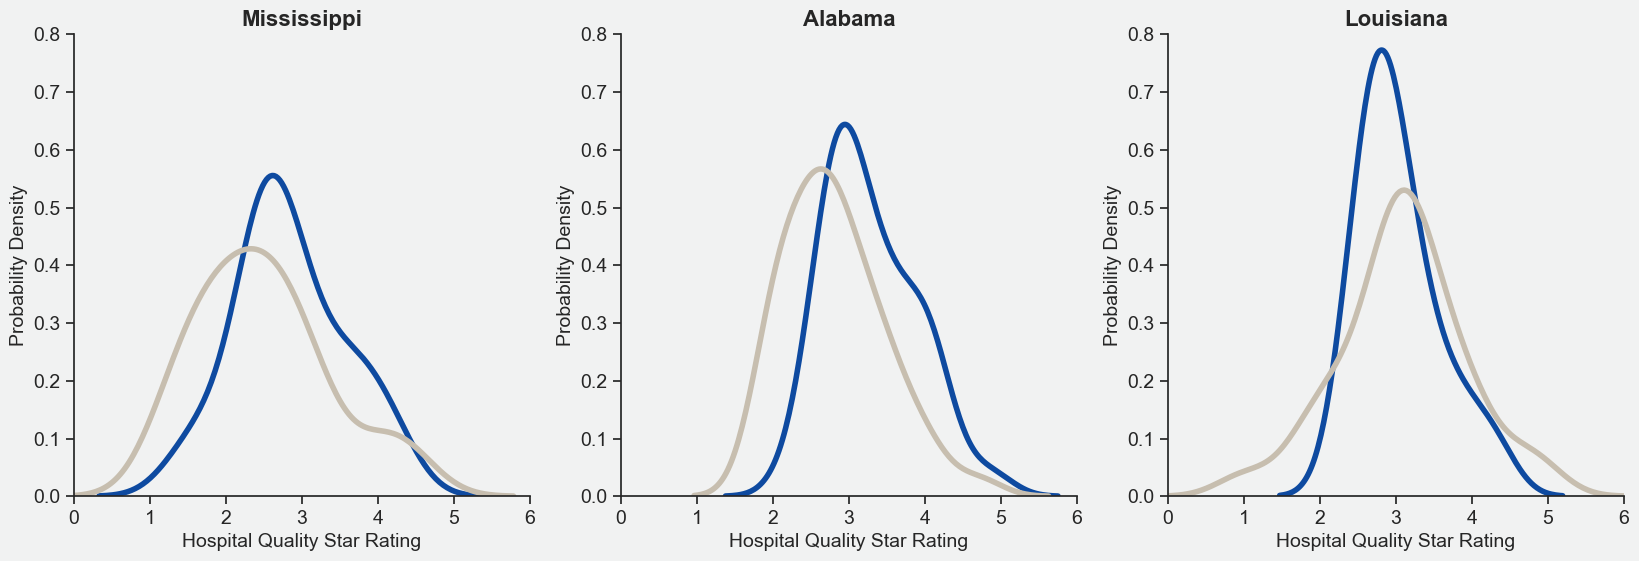

In [86]:
# Just plot KDEs for all states
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Mississippi'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette, linewidth = 4,
            legend = False).set(title = 'Mississippi', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')
plt.tick_params(labelsize = 14)

plt.subplot(1, 3, 2)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Alabama'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette, linewidth = 4,
            legend = False).set(title = 'Alabama', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')
plt.tick_params(labelsize = 14)

plt.subplot(1, 3, 3)
sns.kdeplot(facility_ratings[facility_ratings['State'] == 'Louisiana'], x = 'Hospital overall rating', hue = 'County HPSA Status',
            common_norm = False, palette = shortage_palette, linewidth = 4,
            legend = False).set(title = 'Louisiana', xlim = (0, 6), ylim = (0, 0.8), xlabel = 'Hospital Quality Star Rating', ylabel = 'Probability Density')
plt.tick_params(labelsize = 14)

plt.savefig("star_rating_kde.png")
    
plt.show()

---
### Are there any qualitative differences in hospitals in shortage areas vs. non-shortage areas?
#### **Answer:  For all three states, most hospitals in non-shortage areas are private (for-profit and non-profit), and most hospitals in shortage areas are government-owned.**

For Alabama, there are NO children's hospitals or VA hospitals in shortage areas.  All of the critical access hospitals are in shortage areas; none are in non-shortage areas.

For Louisiana, there are NO children's hospitals in shortage areas.  There are critical access hospitals in both shortage and non-shortage areas, but a higher percentage exist in shortage areas.

For Mississippi, no children's hospitals exist in shortage and non-shortage areas.  There are critical access hospitals in both shortage and non-shortage areas, but a MUCH higher percentage exist in shortage areas (more than acute care hospitals).

In [23]:
# Get the sample size by Hospital Type for shortage vs. non-shortage areas
cms.groupby(['State', 'County HPSA Status'])['Hospital Type'].value_counts()

State        County HPSA Status  Hospital Type                       
Alabama      Non-Shortage Area   Acute Care Hospitals                    354
                                 Psychiatric                              42
                                 Childrens                                16
                                 Acute Care - Veterans Administration      3
             Shortage Area       Acute Care Hospitals                    307
                                 Critical Access Hospitals                37
                                 Psychiatric                               5
Louisiana    Non-Shortage Area   Acute Care Hospitals                    557
                                 Psychiatric                             177
                                 Critical Access Hospitals               104
                                 Childrens                                16
                                 Acute Care - Veterans Administration      3
      

In [24]:
# Get the sample size by Hospital Ownership for shortage vs. non-shortage areas
cms.groupby(['State', 'County HPSA Status'])['Hospital Ownership'].value_counts()

State        County HPSA Status  Hospital Ownership                         
Alabama      Non-Shortage Area   Proprietary                                    135
                                 Voluntary non-profit - Private                 103
                                 Government - Hospital District or Authority     98
                                 Government - State                              34
                                 Voluntary non-profit - Church                   16
                                 Voluntary non-profit - Other                    10
                                 Government - Federal                             8
                                 Government - Local                               8
                                 Veterans Health Administration                   3
             Shortage Area       Government - Hospital District or Authority    141
                                 Proprietary                                     79

In [25]:
# Get the sample size by Emergency Services for shortage vs. non-shortage areas
cms.groupby(['State', 'County HPSA Status'])['Emergency Services'].value_counts()

State        County HPSA Status  Emergency Services
Alabama      Non-Shortage Area   Yes                   382
                                 No                     33
             Shortage Area       Yes                   331
                                 No                     18
Louisiana    Non-Shortage Area   Yes                   550
                                 No                    307
             Shortage Area       Yes                   252
                                 No                     35
Mississippi  Non-Shortage Area   Yes                   312
                                 No                     62
             Shortage Area       Yes                   379
                                 No                     43
Name: Emergency Services, dtype: int64

In [26]:
# Get the sample size by Meets criteria for meaningful use of EHRs for shortage vs. non-shortage areas
cms.groupby(['State', 'County HPSA Status'])['Meets criteria for meaningful use of EHRs'].value_counts()

State        County HPSA Status  Meets criteria for meaningful use of EHRs
Alabama      Non-Shortage Area   Y                                            224
             Shortage Area       Y                                            178
Louisiana    Non-Shortage Area   Y                                            375
             Shortage Area       Y                                            134
Mississippi  Non-Shortage Area   Y                                            184
             Shortage Area       Y                                            213
Name: Meets criteria for meaningful use of EHRs, dtype: int64

---
### If we limit our analysis to Acute Care Hospitals only, how does the average hospital star ratings compare in shortage areas versus non-shortage areas?
#### **Answer**

In [27]:
# Create a new dataframe for only acute care hospitals
cms_acute = cms[cms['Hospital Type'] == 'Acute Care Hospitals']

In [28]:
# Get descriptive statistics for Hospital overall rating using the new cms_acute dataframe
cms_acute.groupby(['State', 'County HPSA Status'])['Hospital overall rating'].describe()

count      mean       std  min  25%  50%  75%  \
State       County HPSA Status                                                  
Alabama     Non-Shortage Area   340.0  2.764706  0.857341  1.0  2.0  3.0  3.0   
            Shortage Area       240.0  3.266667  0.830721  1.0  3.0  3.0  4.0   
Louisiana   Non-Shortage Area   416.0  3.040865  0.954766  1.0  2.0  3.0  4.0   
            Shortage Area       119.0   3.05042  0.821829  1.0  3.0  3.0  4.0   
Mississippi Non-Shortage Area   252.0  2.396825  0.990628  1.0  2.0  2.0  3.0   
            Shortage Area       141.0  2.801418  0.896181  1.0  2.0  3.0  3.0   

                                max  
State       County HPSA Status       
Alabama     Non-Shortage Area   5.0  
            Shortage Area       5.0  
Louisiana   Non-Shortage Area   5.0  
            Shortage Area       5.0  
Mississippi Non-Shortage Area   5.0  
            Shortage Area       5.0

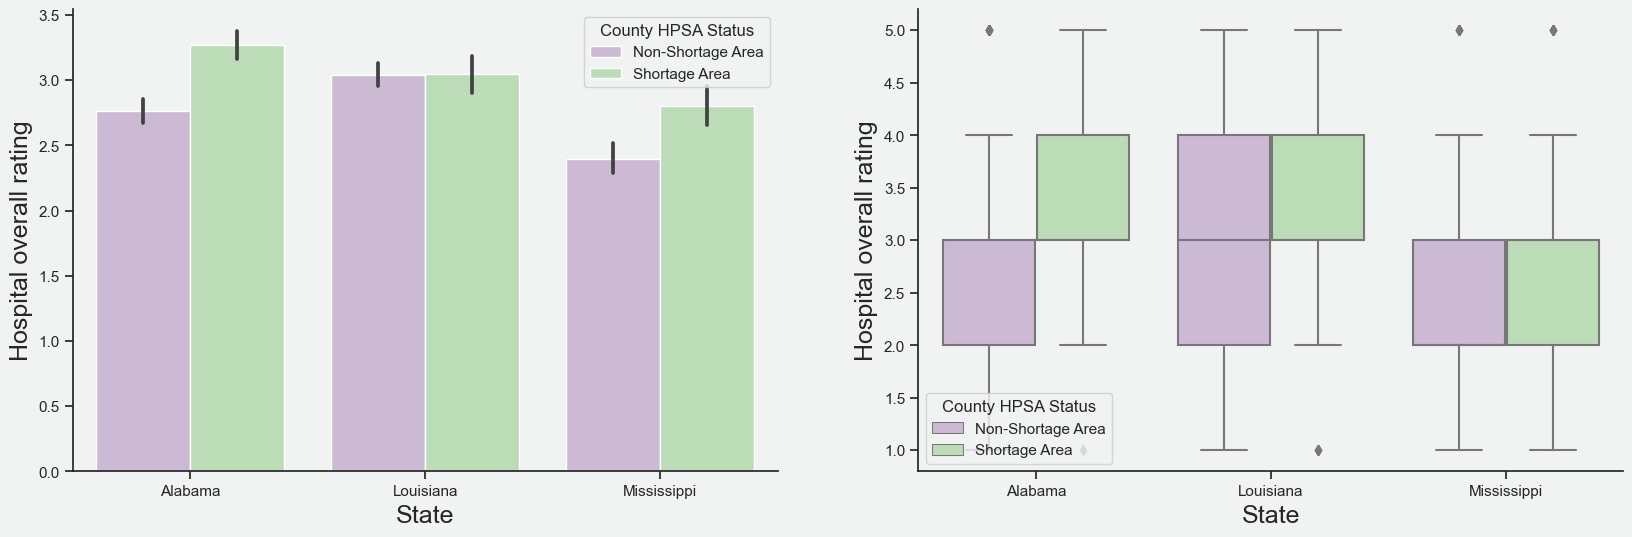

In [29]:
# Create barplot and boxplot for Hospital overall rating by HPSA County Status and state
cms_cleaned_acute = cms_acute.dropna(subset = ['Hospital overall rating', 'County HPSA Status', 'State'])

plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_cleaned_acute, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'PRGn')

plt.subplot(1, 2, 2)
sns.boxplot(cms_cleaned_acute, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'PRGn')

plt.show()

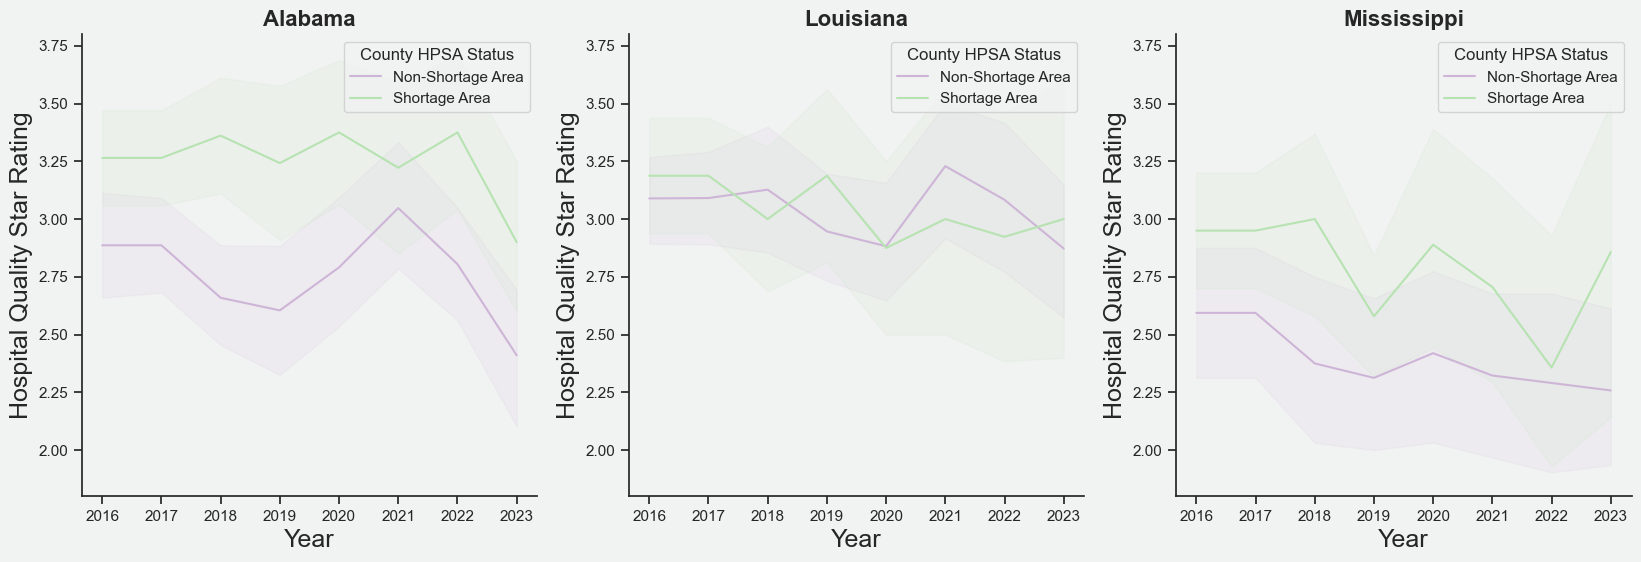

In [30]:
# Create line plot for Hospital overall rating by year, HPSA county status, & state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.lineplot(cms_acute[cms_acute['State'] == 'Alabama'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = 'PRGn', err_kws = {'alpha': 0.1}).set(title = 'Alabama', ylim = (1.8, 3.8), ylabel = 'Hospital Quality Star Rating')

plt.subplot(1, 3, 2)
sns.lineplot(cms_acute[cms_acute['State'] == 'Louisiana'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = 'PRGn', err_kws = {'alpha': 0.1}).set(title = 'Louisiana', ylim = (1.8, 3.8), ylabel = 'Hospital Quality Star Rating')

plt.subplot(1, 3, 3)
sns.lineplot(cms_acute[cms_acute['State'] == 'Mississippi'], x = 'Year', y = 'Hospital overall rating', hue = 'County HPSA Status',
             palette = 'PRGn', err_kws = {'alpha': 0.1}).set(title = 'Mississippi', ylim = (1.8, 3.8), ylabel = 'Hospital Quality Star Rating')

plt.show()

---
### For Acute Care Hospitals in shortage areas, what is the median HPSA by star rating level?  (This is for all years, all three states combined.)
#### **Answer: For all star rating levels, the HPSA Score distributions are right-tailed, meaning that are some high-need hospitals with high HPSA Scores that pull the average up for a given star level.  In terms of medians, HPSA Scores are slightly higher for the lower star levels, and slightly lower for the higher star levels.**
1 star = 15.0 median HPSA Score<br>
2 star = 13.0<br>
3 star = 13.0<br>
4 star = 13.0<br>
5 star = 12.0

In [31]:
# Subset the dataset to only include rows from shortage areas
cms_shortage = cms_acute[cms_acute['County HPSA Status'] == 'Shortage Area']

# Check that the indexing worked
cms_shortage['County HPSA Status'].value_counts()

Shortage Area    660
Name: County HPSA Status, dtype: int64

In [32]:
# Check for nulls in the HPSA Score column
cms_shortage['HPSA Score'].isna().sum()

0

In [33]:
# Check for nulls in the Hospital overall rating column
cms_shortage['Hospital overall rating'].isna().sum()

160

In [34]:
# Only keep rows that have both an HPSA score and star rating
cms_shortage = cms_shortage.dropna(subset = ['Hospital overall rating'])

# # Check that the dropping of rows worked
cms_shortage['Hospital overall rating'].isna().sum()

0

In [35]:
# Get descriptive statistics for HPSA score by star rating level
cms_shortage.groupby('Hospital overall rating')['HPSA Score'].describe()

,count,mean,std,min,25%,50%,75%,max
Hospital overall rating,,,,,,,,
1,12.0,15.750000,4.287932,10.0,13.0,15.0,21.0,21.0
2,108.0,14.009259,2.888894,9.0,12.0,13.0,16.0,21.0
3,231.0,14.108225,3.039089,9.0,12.0,13.0,16.5,22.0
4,124.0,13.887097,2.982904,5.0,12.0,13.0,16.0,21.0
5,25.0,13.320000,3.105372,9.0,12.0,12.0,15.0,20.0


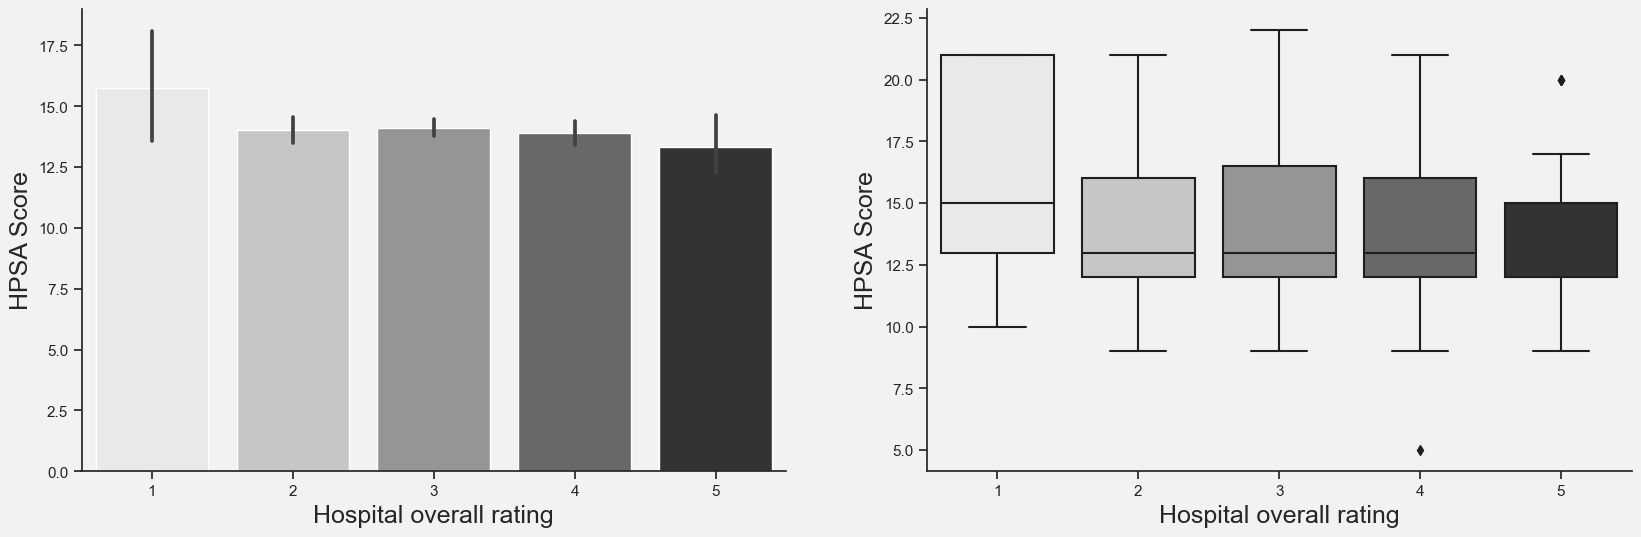

In [36]:
# Create barplot and boxplot for HPSA Score by star rating level
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_shortage, x = 'Hospital overall rating', y = 'HPSA Score', palette = 'Greys')

plt.subplot(1, 2, 2)
sns.boxplot(cms_shortage, x = 'Hospital overall rating', y = 'HPSA Score', palette = 'Greys')

plt.show()

/var/folders/19/md1d568j3j72wrqkm3yr4s8r0000gn/T/ipykernel_11391/3466016171.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(cms_shortage, x = 'Hospital overall rating', y = 'HPSA Score', palette = 'Greys')


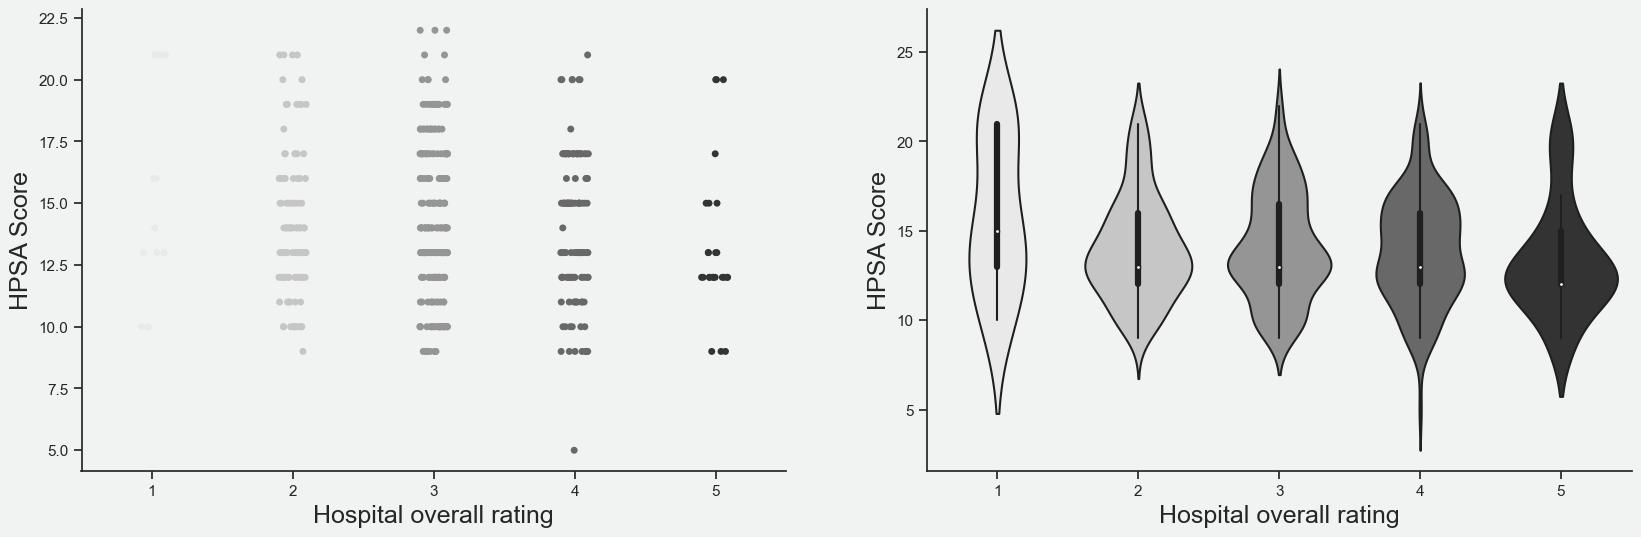

In [37]:
# Create strip plot and violin plot for HPSA Score by star rating level
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.stripplot(cms_shortage, x = 'Hospital overall rating', y = 'HPSA Score', palette = 'Greys')

plt.subplot(1, 2, 2)
sns.violinplot(cms_shortage, x = 'Hospital overall rating', y = 'HPSA Score', palette = 'Greys')

plt.show()

---
### For hospitals in shortage areas, what is the average HPSA score by star rating level for each state?
#### **Answer: The HPSA Score distributions for Alabama & Louisiana are quite variable and don't follow a predictable pattern.  Counterintuitively for Alabama & Louisiana, as star ratings increase at the 2, 3, 4 level, median HPSA scores also increase.**
2 stars - 13.0<br>
3 stars - 13.0<br>
4 stars - 15.0 for Alabama

2 stars - 12.0<br>
3 stars - 13.0<br>
4 stars - 15.0 for Louisiana

#### **The HPSA Score distributions for Mississippi are also variable, but there is a more predictable pattern.  As the star rating level increases, the median HPSA score decreases.**
1 star - 21.0<br>
2 stars - 14.0<br>
3 stars - 14.0<br>
4 stars - 12.0<br>
5 stars - 12.0 for Mississippi

In [38]:
# Get descriptive statistics for HPSA score by star rating level for each state
cms_shortage.groupby(['State', 'Hospital overall rating'])['HPSA Score'].describe()

count       mean       std   min    25%  \
State       Hospital overall rating                                            
Alabama     1                          1.0  10.000000       NaN  10.0  10.00   
            2                         40.0  13.725000  2.846388   9.0  12.50   
            3                        109.0  14.018349  3.308188   9.0  12.00   
            4                         74.0  14.013514  3.116431   5.0  12.00   
            5                         16.0  13.875000  3.383785   9.0  12.00   
Louisiana   1                          4.0  12.250000  1.500000  10.0  12.25   
            2                         22.0  13.045455  2.380021  10.0  12.00   
            3                         60.0  14.100000  2.784339  10.0  12.00   
            4                         30.0  14.800000  1.882771  12.0  13.00   
            5                          3.0  14.333333  2.309401  13.0  13.00   
Mississippi 1                          7.0  18.571429  3.101459  14.0  16.00   
            2                         46.0  14.717391  3.023339  10.0  12.25   
            3                         62.0  14.274194  2.811973   9.0  12.25   
            4                         20.0  12.050000  3.153528   9.0   9.00   
            5                          6.0  11.333333  1.861899   9.0   9.75   

                                      50%    75%   max  
State       Hospital overall rating                     
Alabama     1                        10.0  10.00  10.0  
            2                        13.0  15.00  20.0  
            3                        13.0  16.00  22.0  
            4                        15.0  15.75  21.0  
            5                        12.0  15.00  20.0  
Louisiana   1                        13.0  13.00  13.0  
            2                        12.0  15.25  18.0  
            3                        13.0  17.00  18.0  
            4                        15.0  17.00  17.0  
            5                        13.0  15.00  17.0  
Mississippi 1                        21.0  21.00  21.0  
            2                        14.0  16.00  21.0  
            3                        14.0  17.00  19.0  
            4                        12.0  13.25  18.0  
            5                        12.0  12.75  13.0

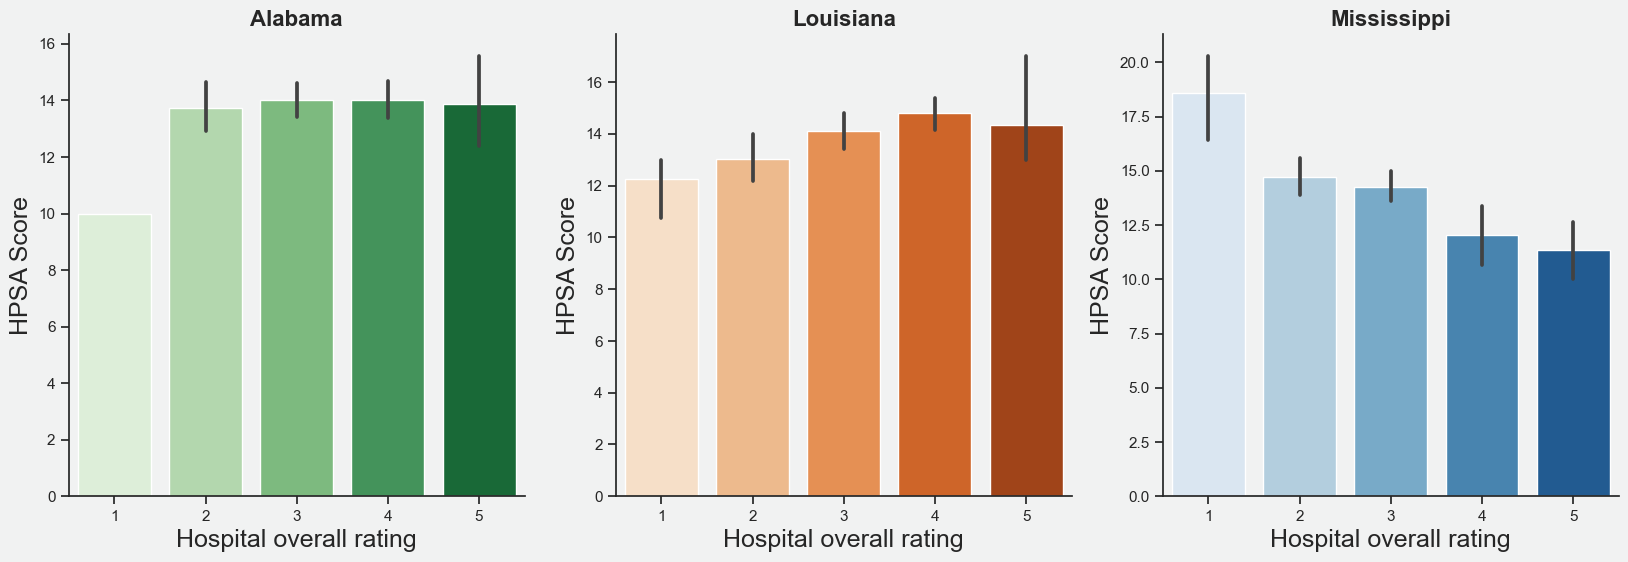

In [39]:
# Create barplots for average HPSA score by star rating level for each state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(cms_shortage[cms_shortage['State'] == 'Alabama'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Greens').set(title = 'Alabama')

plt.subplot(1, 3, 2)
sns.barplot(cms_shortage[cms_shortage['State'] == 'Louisiana'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Oranges').set(title = 'Louisiana')

plt.subplot(1, 3, 3)
sns.barplot(cms_shortage[cms_shortage['State'] == 'Mississippi'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Blues').set(title = 'Mississippi')

plt.show()

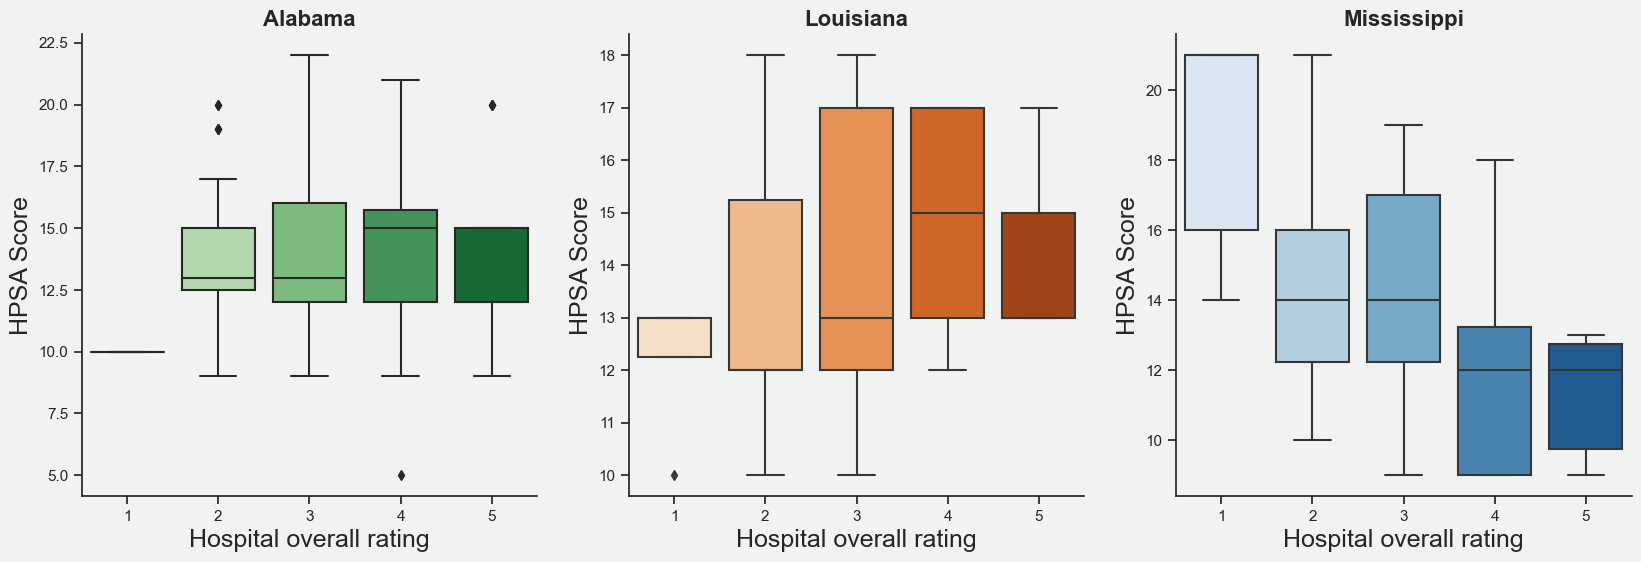

In [40]:
# Create boxplots for average HPSA score by star rating level for each state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.boxplot(cms_shortage[cms_shortage['State'] == 'Alabama'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Greens').set(title = 'Alabama')

plt.subplot(1, 3, 2)
sns.boxplot(cms_shortage[cms_shortage['State'] == 'Louisiana'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Oranges').set(title = 'Louisiana')

plt.subplot(1, 3, 3)
sns.boxplot(cms_shortage[cms_shortage['State'] == 'Mississippi'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Blues').set(title = 'Mississippi')

plt.show()

/var/folders/19/md1d568j3j72wrqkm3yr4s8r0000gn/T/ipykernel_11391/3094822193.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(cms_shortage[cms_shortage['State'] == 'Alabama'], x = 'Hospital overall rating',
/var/folders/19/md1d568j3j72wrqkm3yr4s8r0000gn/T/ipykernel_11391/3094822193.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(cms_shortage[cms_shortage['State'] == 'Louisiana'], x = 'Hospital overall rating',
/var/folders/19/md1d568j3j72wrqkm3yr4s8r0000gn/T/ipykernel_11391/3094822193.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(cms_shortage[cms_shortage['State'] == 'Mississippi'], x = 'Hospital overall rating',


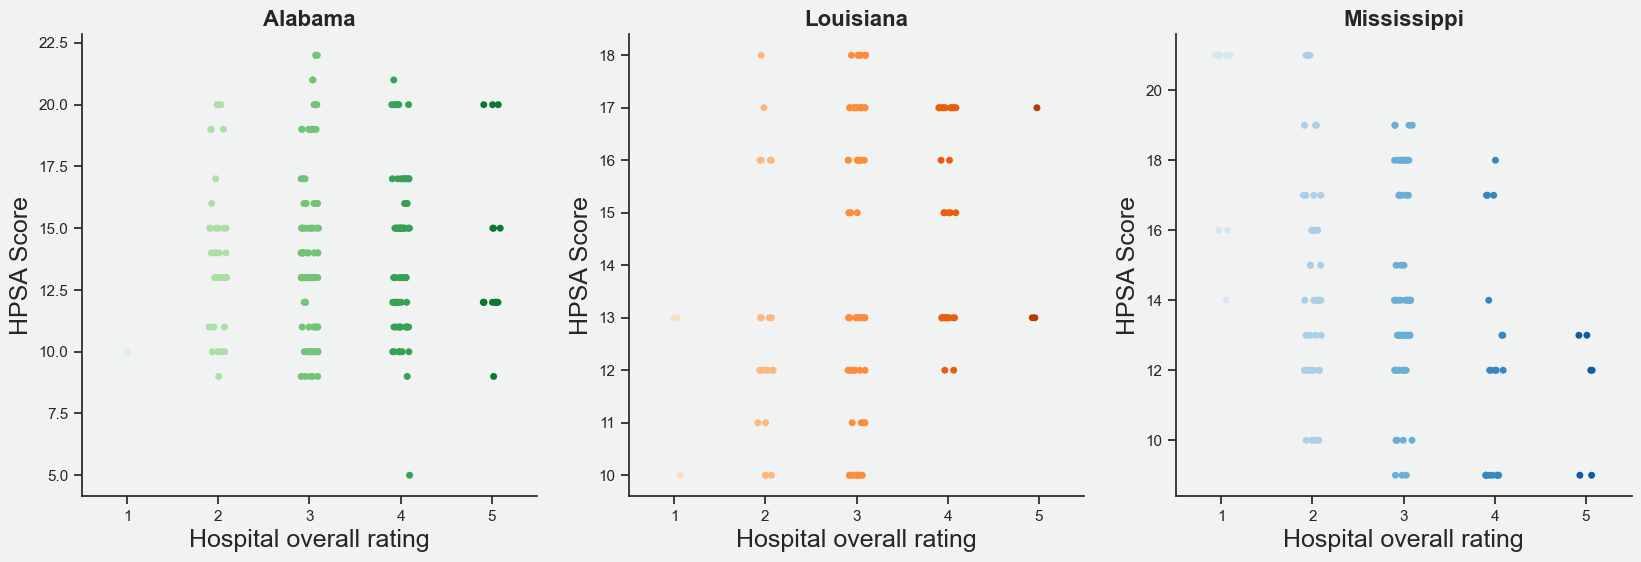

In [41]:
# Create stripplots for average HPSA score by star rating level for each state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.stripplot(cms_shortage[cms_shortage['State'] == 'Alabama'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Greens').set(title = 'Alabama')

plt.subplot(1, 3, 2)
sns.stripplot(cms_shortage[cms_shortage['State'] == 'Louisiana'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Oranges').set(title = 'Louisiana')

plt.subplot(1, 3, 3)
sns.stripplot(cms_shortage[cms_shortage['State'] == 'Mississippi'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Blues').set(title = 'Mississippi')

plt.show()

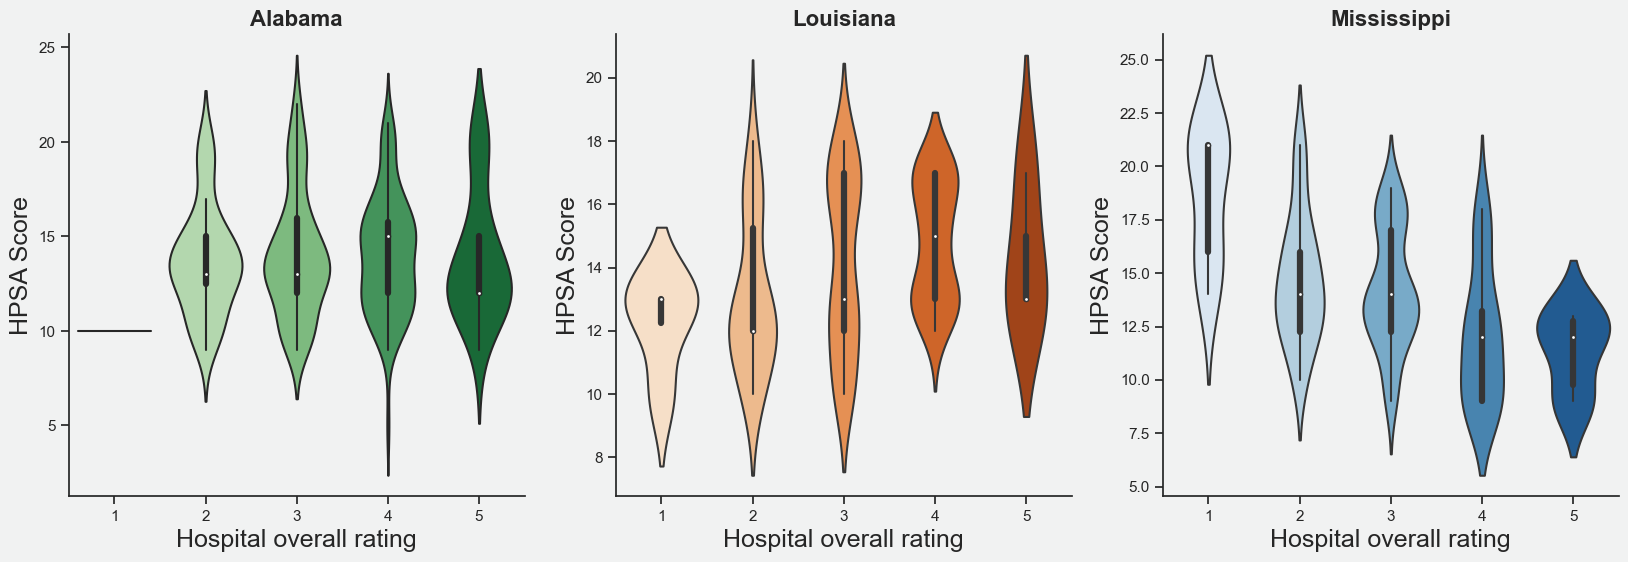

In [42]:
# Create violinplots for average HPSA score by star rating level for each state
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.violinplot(cms_shortage[cms_shortage['State'] == 'Alabama'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Greens').set(title = 'Alabama')

plt.subplot(1, 3, 2)
sns.violinplot(cms_shortage[cms_shortage['State'] == 'Louisiana'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Oranges').set(title = 'Louisiana')

plt.subplot(1, 3, 3)
sns.violinplot(cms_shortage[cms_shortage['State'] == 'Mississippi'], x = 'Hospital overall rating',
            y = 'HPSA Score', palette = 'Blues').set(title = 'Mississippi')

plt.show()

### Who are the Acute Care Hospitals in Mississippi at the 1- and 2-star rating levels with high HPSA scores (i.e. > 18.0)?

In [43]:
# Define conditions for indexing the cms_shortage dataframe
condition_1 = (cms_shortage['State'] == 'Mississippi')
condition_2 = (cms_shortage['Hospital overall rating'] == 1) | (cms_shortage['Hospital overall rating'] == 2)
condition_3 = (cms_shortage['HPSA Score'] > 18)

In [44]:
# Get their Facility IDs
high_needs_hospitals = cms_shortage[condition_1 & condition_2 & condition_3]['Facility ID'].unique()

In [45]:
# Get all rows from the high-needs hospitals and store in new dataframe called hn
hn = cms[cms['Facility ID'].isin(high_needs_hospitals)]

In [46]:
# Get the most recent year of data for these two facilities
hn[hn['Year'] == 2023]

,Year,Quarter,Facility ID,Facility Name,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,...,County HPSA Status,Designation Type,HPSA Score,HPSA FTE,HPSA Designation Population,% of Population Below 100% Poverty,HPSA Formal Ratio,Rural Status,HPSA Provider Ratio Goal,HPSA Shortage
2633,2023,Q3,250082,DELTA HEALTH SYSTEM - THE MEDICAL CENTER,GREENVILLE,Mississippi,38704,Acute Care Hospitals,Government - Local,Yes,...,Shortage Area,High Needs Geographic HPSA,21.0,1.05,5630.0,33.1,5362:1,Rural,3000:1,0.83
2638,2023,Q3,250095,SOUTH SUNFLOWER COUNTY HOSPITAL,INDIANOLA,Mississippi,38751,Acute Care Hospitals,Government - Local,Yes,...,Shortage Area,High Needs Geographic HPSA,19.0,5.13,21868.0,31.7,4263:1,Rural,3000:1,2.16


---
### What is the relationship between HPSA Score in a county and hospital star rating in shortage areas?  (Generate a scatterplot.)

In [47]:
# Get info about the acute_subset dataframe (only acute care hospitals; NaNs have been dropped from Hospital overall rating column)
acute_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1514 entries, 0 to 2663
Data columns (total 53 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Year                                                   1514 non-null   int64  
 1   Quarter                                                1514 non-null   object 
 2   Facility ID                                            1514 non-null   object 
 3   Facility Name                                          1514 non-null   object 
 4   City                                                   1514 non-null   object 
 5   State                                                  1514 non-null   object 
 6   ZIP Code                                               1514 non-null   int64  
 7   Hospital Type                                          1514 non-null   object 
 8   Hospital Ownership                              

In [48]:
# For each state, group by county and shortage area designation
a_counties = acute_subset.groupby(['State', 'Common State County FIPS Code', 'County HPSA Status'])

In [49]:
# Get descriptive statistics for Hospital overall rating and store in a new dataframe called county_stars
county_stars = a_counties['Hospital overall rating'].describe().reset_index(level = ['State', 'Common State County FIPS Code', 'County HPSA Status'])

In [50]:
# Get info about county_hpsa
county_stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          139 non-null    object 
 1   Common State County FIPS Code  139 non-null    object 
 2   County HPSA Status             139 non-null    object 
 3   count                          139 non-null    Float64
 4   mean                           139 non-null    Float64
 5   std                            138 non-null    Float64
 6   min                            139 non-null    Float64
 7   25%                            139 non-null    Float64
 8   50%                            139 non-null    Float64
 9   75%                            139 non-null    Float64
 10  max                            139 non-null    Float64
dtypes: Float64(8), object(3)
memory usage: 13.2+ KB


In [51]:
# Get descriptive statistics for HPSA Score and store in a new dataframe called county_hpsa
county_hpsa = a_counties['HPSA Score'].describe().reset_index(level = ['State', 'Common State County FIPS Code', 'County HPSA Status'])

In [52]:
# Drop NaNs from mean column in county_hpsa (since non-shortage counties don't have a reported HPSA Score)
county_hpsa.dropna(subset = 'mean', inplace = True)

In [53]:
# Check that this county_hpsa only includes counties from shortage areas, since shortage areas have HPSA Scores (non-shortage areas do not)
county_hpsa['County HPSA Status'].unique()

array(['Shortage Area'], dtype=object)

In [54]:
# Iterate through each county, and add a column to the county_hpsa dataframe for the corresponding average star rating in that county
for county in county_hpsa['Common State County FIPS Code']:
    county_row = county_stars[county_stars['Common State County FIPS Code'] == county]
    county_rating = float(county_row['mean'].iloc[0])
    county_hpsa.loc[county_hpsa['Common State County FIPS Code'] == county, 'Hospital Quality Star Rating'] = county_rating

In [55]:
# Check first few rows of county_hpsa to see that the column addition looks good
county_hpsa.head()

,State,Common State County FIPS Code,County HPSA Status,count,mean,std,min,25%,50%,75%,max,Hospital Quality Star Rating
0,Alabama,01001,Shortage Area,8.0,15.0,0.0,15.0,15.0,15.0,15.0,15.0,4.125000
2,Alabama,01005,Shortage Area,7.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,2.857143
3,Alabama,01007,Shortage Area,2.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,3.000000
4,Alabama,01011,Shortage Area,3.0,22.0,0.0,22.0,22.0,22.0,22.0,22.0,3.000000
5,Alabama,01013,Shortage Area,12.0,13.0,0.0,13.0,13.0,13.0,13.0,13.0,2.750000


In [56]:
# Rename the mean column to HPSA Score
county_hpsa.rename(columns = {'mean': 'HPSA Score'}, inplace = True)

In [57]:
# Get info for the dataframe one last time to make sure there are no nulls
county_hpsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 138
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          66 non-null     object 
 1   Common State County FIPS Code  66 non-null     object 
 2   County HPSA Status             66 non-null     object 
 3   count                          66 non-null     float64
 4   HPSA Score                     66 non-null     float64
 5   std                            65 non-null     float64
 6   min                            66 non-null     float64
 7   25%                            66 non-null     float64
 8   50%                            66 non-null     float64
 9   75%                            66 non-null     float64
 10  max                            66 non-null     float64
 11  Hospital Quality Star Rating   66 non-null     float64
dtypes: float64(9), object(3)
memory usage: 6.7+ KB


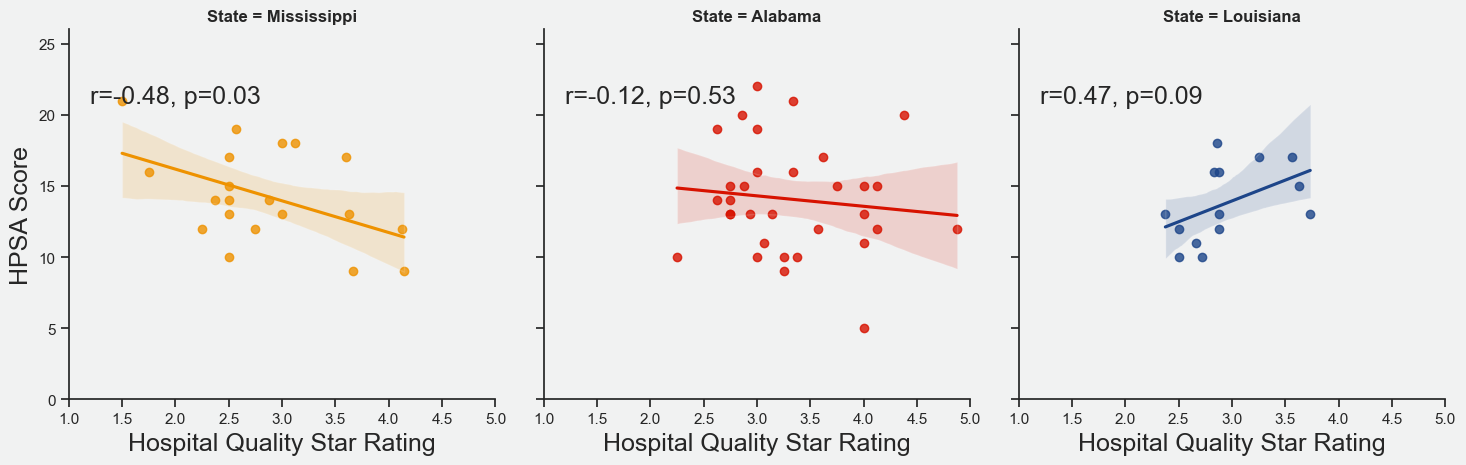

In [58]:
# Define a function annotate that gets the current plot in the grid and annotates the pearson r and p-value onto the plot
def annotate(data, x, y, **kws):
    bool_mask = (data[x].notna()) & (data[y].notna())
    r, p = sp.stats.pearsonr(data.loc[bool_mask, x], data.loc[bool_mask, y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2f}'.format(r, p), transform = ax.transAxes)

# Create scatterplots for each state
scatter = sns.lmplot(county_hpsa, x = 'Hospital Quality Star Rating', y = 'HPSA Score', col = 'State', hue = 'State',
                     col_order = ['Mississippi', 'Alabama', 'Louisiana'], palette = custom_palette).set(xlim = (1, 5), ylim = (0, 26))

# Plot the Pearson r values and p values
scatter.map_dataframe(annotate, x = 'Hospital Quality Star Rating', y = 'HPSA Score')

plt.show()